In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import itertools
import csv,codecs,nltk,re
from nltk.stem.isri import ISRIStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import itertools
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer
from sklearn.model_selection import cross_validate,train_test_split,KFold
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, NuSVC , LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import random
nltk.download('stopwords')
from nltk.stem import SnowballStemmer, ISRIStemmer
import string
from nltk.corpus import stopwords 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Read csv file**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Clime11_3.csv to Clime11_3.csv


In [ ]:
df = pd.read_csv("Clime11_3.csv")
df.dropna(inplace=True)
df.head()

,ClaimID,Category,Claim,ClaimSource,ClaimLabel
0,1,Entertainment,تنبأت الولايات المتحدة الأمريكية بتفشي فيروس ك...,shorturl.at/csuFZ,False
1,2,Social,قامت الصين بتصفية -قتل- المصابين بفيروس كورونا...,shorturl.at/djsx7,False
2,3,Social,تساقط العديد من الأشخاص في شوارع الصين بسبب إص...,shorturl.at/fDW39,False
3,4,Social,سافر شابًا عربيًا وحيداً على متن طائرة متجهة م...,shorturl.at/rEFV9,False
4,5,Social,تنتشر الأوبئة القاتلة في العالم في العام العشر...,shorturl.at/HIMS5,False


In [ ]:
df= pd.read_csv("Clime11_3.csv")
df.drop('ClaimSource',axis='columns', inplace=True)

In [ ]:
df.head()

,ClaimID,Category,Claim,ClaimLabel
0,1,Entertainment,تنبأت الولايات المتحدة الأمريكية بتفشي فيروس ك...,False
1,2,Social,قامت الصين بتصفية -قتل- المصابين بفيروس كورونا...,False
2,3,Social,تساقط العديد من الأشخاص في شوارع الصين بسبب إص...,False
3,4,Social,سافر شابًا عربيًا وحيداً على متن طائرة متجهة م...,False
4,5,Social,تنتشر الأوبئة القاتلة في العالم في العام العشر...,False


In [ ]:
# check if there is null data
df.isnull().sum()

ClaimID        0
Category       0
Claim          0
ClaimSource    0
ClaimLabel     0
dtype: int64

In [ ]:
df.shape

(188, 5)

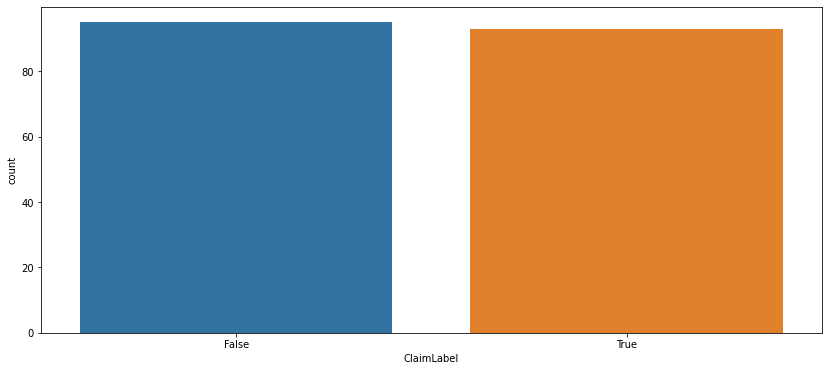

In [ ]:
plt.figure(figsize=(14,6))
sns.countplot(data=df, x='ClaimLabel')

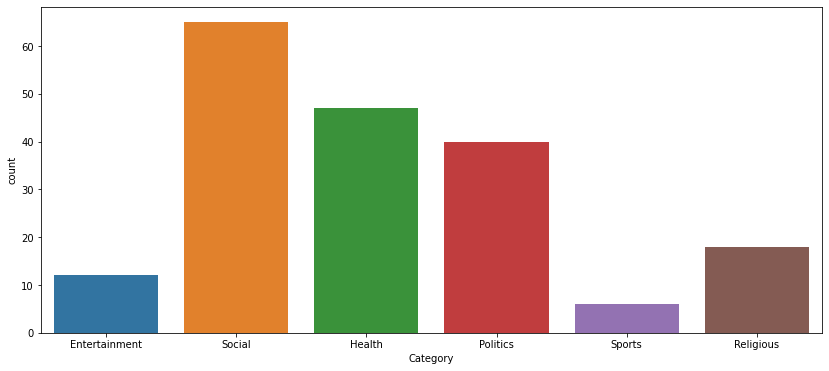

In [ ]:
plt.figure(figsize=(14,6))
sns.countplot(data=df, x='Category')

**Data preprocessing**

In [ ]:
df.Claim[8]

'هجوم أسراب من طائر الغراب والبعوض على شوارع الصين بحثاً عن جثث الهالكين بفيروس كورونا (كوفيد-19) بعد تصاعد رائحتها.'

In [ ]:
search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations


# remove tashkeel
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

# remove diacritics from text
def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    return text

# setmming to restore original world
def LightStemmer(wordList):
    result = list()
    stemmer = ISRIStemmer()
    for word in wordList:
        word = stemmer.norm(word, num=1)
        word = stemmer.pre32(word)        
        word = stemmer.suf32(word)        
        word = stemmer.waw(word)          
        word = stemmer.norm(word, num=2)  
        # word = stemmer.stem(word)
        result.append(word)
                
    return ' '.join(result)


def cleanStem(text):
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = LightStemmer(text.split(' '))

    return text


**Evaluation**

In [ ]:
tweets = df['Claim']
labels = df['ClaimLabel']
df.ClaimLabel.value_counts()

False    95
True     93
Name: ClaimLabel, dtype: int64

In [ ]:
# split data to train and test

X_train, X_test, y_train, y_test = train_test_split(tweets, labels,test_size=0.2)

In [ ]:
X_train = X_train.apply(lambda x: cleanStem(x)) 

In [ ]:
X_train.head()

182    #بورصه مصر تنهي جلسات لون احمر ثلاثي يتراجع بن...
123    لا تحمي لقاح التهاب رءوي من فيروس كورو مستجد (...
87              صرح اردوغ انه سيفتح مساجد ترك في شهر رمض
39     اسلم 20 ملي صيني بعد اثب ان فيروس كورو (كوفيد ...
128    سلمت منظمه صحه عالميه شحنه امداد طبيه عاجله لو...
Name: Claim, dtype: object

In [ ]:
data=df

In [ ]:
cl=[LogisticRegression,SVC, NuSVC , LinearSVC,DecisionTreeClassifier]
def get_count(data):
    cc = pd.DataFrame()
    cc['countt']=[len(t.split())for t in data.text] 
    return cc   

In [ ]:
result="Classifier"+'*'+" Accuracy * f1_score * Recall * precision"+"\n"
X_train, X_test, y_train, y_test = \
    train_test_split(data['Claim'], data['ClaimLabel'],test_size=0.2, random_state = 0)

In [ ]:
def BoW_Evaluataion(Model, clfName):
    vectorizer = CountVectorizer(max_df=1.0, min_df=1).fit(X_train)
    X_train_vectorized = vectorizer.transform(X_train)
    Model.fit(X_train_vectorized, y_train)
    global result
    
    predictions = Model.predict(vectorizer.transform(X_test))
    result+=clfName+'*BoW'+'*'+str(accuracy_score(y_test, predictions))+'*'+str(f1_score(y_test, predictions,average='weighted'))+'*'+str(recall_score(y_test, predictions,average='weighted'))+'*'+str(precision_score(y_test, predictions,average='weighted'))+"\n"

    #result+=clfName+'*BoW*'+'*'+str(accuracy_score(y_test, predictions))+'*'+str(f1_score(y_test, predictions,average='weighted'))+'*'+str(recall_score(y_test, predictions,average='weighted'))+'*'+str()+'*'+str(precision_score(y_test, predictions,average='weighted'))+'*'+str(Model.best_score_)+'*'+str( Model.best_params_)+"\n"
    print("accuracy",accuracy_score(y_test, predictions))
    print("f1_score",f1_score(y_test, predictions,average='weighted'))
    print("recall",recall_score(y_test, predictions,average='weighted'))
    print("precision",precision_score(y_test, predictions,average='weighted'))    
    print ('\n clasification report:\n', classification_report(y_test, predictions))

In [ ]:
for classifier in cl:
    BoW_Evaluataion(classifier(),classifier.__name__)

accuracy 0.8421052631578947
f1_score 0.8412280701754387
recall 0.8421052631578947
precision 0.8594497607655501

 clasification report:
               precision    recall  f1-score   support

       False       0.77      0.94      0.85        18
        True       0.94      0.75      0.83        20

    accuracy                           0.84        38
   macro avg       0.86      0.85      0.84        38
weighted avg       0.86      0.84      0.84        38

accuracy 0.7368421052631579
f1_score 0.7278708133971291
recall 0.7368421052631579
precision 0.7921727395411606

 clasification report:
               precision    recall  f1-score   support

       False       0.65      0.94      0.77        18
        True       0.92      0.55      0.69        20

    accuracy                           0.74        38
   macro avg       0.79      0.75      0.73        38
weighted avg       0.79      0.74      0.73        38

accuracy 0.7894736842105263
f1_score 0.7859354268022999
recall 0.789473684

In [ ]:
from io import StringIO 
df = pd.read_csv(StringIO(result), sep ="*") 
# Print the dataframe 
df

,Classifier,Accuracy,f1_score,Recall,precision
LogisticRegression,BoW,0.842105,0.841228,0.842105,0.859450
SVC,BoW,0.736842,0.727871,0.736842,0.792173
NuSVC,BoW,0.789474,0.785935,0.789474,0.824248
LinearSVC,BoW,0.842105,0.842105,0.842105,0.846784
DecisionTreeClassifier,BoW,0.842105,0.842105,0.842105,0.846784


In [ ]:
result="Classifier"+'*'+" Accuracy * f1_score * Recall * precision"+"\n"

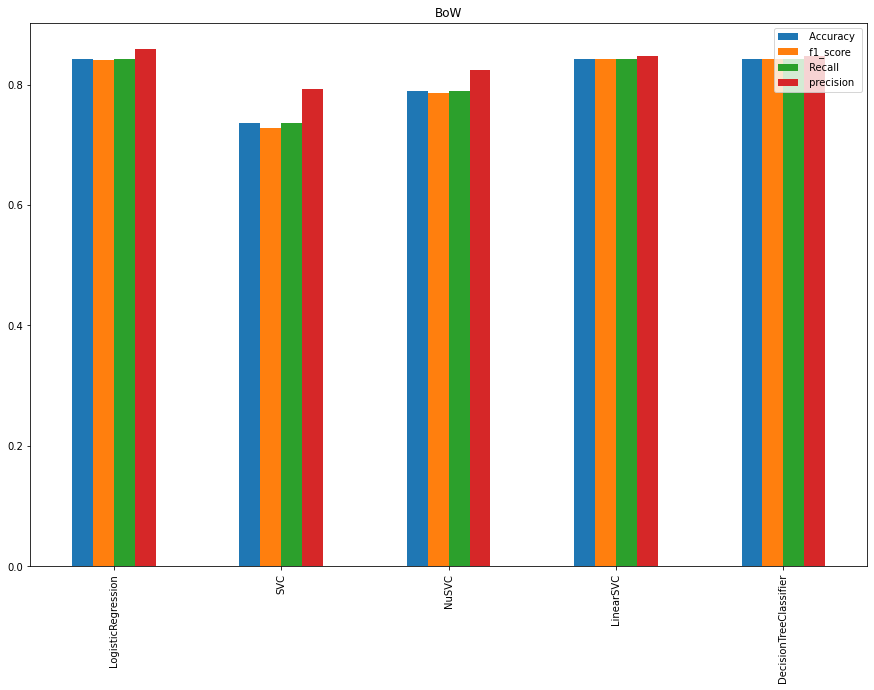

In [ ]:
ax = df.plot.bar(title ="BoW", figsize=(15,10),legend=True)

In [ ]:
def NGram_Evaluataion(Model,clfName,m,n):
    vectorizer = TfidfVectorizer( max_df=1.0, min_df=1,analyzer='word',smooth_idf=True, ngram_range=(m,n))#,analyzer='word'
    vectorizer.fit(X_train)
    X_train_vectorized = vectorizer.transform(X_train)
    Model.fit(X_train_vectorized, y_train)
   
    global result
    predictions = Model.predict(vectorizer.transform(X_test))
    result+=clfName+'*Ngram('+str(m)+','+str(n)+')*'+str(accuracy_score(y_test, predictions))+'*'+str(f1_score(y_test, predictions,average='weighted'))+'*'+str(recall_score(y_test, predictions,average='weighted'))+'*'+str(precision_score(y_test, predictions,average='weighted'))+"\n"

    print(clfName)
    print("accuracy",accuracy_score(y_test, predictions))
    print("f1_score",f1_score(y_test, predictions,average='weighted'))
    print("recall",recall_score(y_test, predictions,average='weighted'))
    print("precision",precision_score(y_test, predictions,average='weighted'))    
    print ('\n clasification report:\n', classification_report(y_test, predictions))


In [ ]:
for classifier in cl:
    NGram_Evaluataion(classifier(),classifier.__name__,1,1) #N-gram range: one word "Unigram"

LogisticRegression
accuracy 0.6842105263157895
f1_score 0.6734449760765551
recall 0.6842105263157895
precision 0.7300944669365722

 clasification report:
               precision    recall  f1-score   support

       False       0.62      0.89      0.73        18
        True       0.83      0.50      0.62        20

    accuracy                           0.68        38
   macro avg       0.72      0.69      0.68        38
weighted avg       0.73      0.68      0.67        38

SVC
accuracy 0.6578947368421053
f1_score 0.6330462987990887
recall 0.6578947368421053
precision 0.7455132083081266

 clasification report:
               precision    recall  f1-score   support

       False       0.59      0.94      0.72        18
        True       0.89      0.40      0.55        20

    accuracy                           0.66        38
   macro avg       0.74      0.67      0.64        38
weighted avg       0.75      0.66      0.63        38

NuSVC
accuracy 0.7105263157894737
f1_score 0.707500

In [ ]:
from io import StringIO 
df = pd.read_csv(StringIO(result), sep ="*") 
# Print the dataframe 
df

,Classifier,Accuracy,f1_score,Recall,precision
LogisticRegression,"Ngram(1,1)",0.684211,0.673445,0.684211,0.730094
SVC,"Ngram(1,1)",0.657895,0.633046,0.657895,0.745513
NuSVC,"Ngram(1,1)",0.710526,0.707500,0.710526,0.729977
LinearSVC,"Ngram(1,1)",0.710526,0.707500,0.710526,0.729977
DecisionTreeClassifier,"Ngram(1,1)",0.789474,0.785885,0.789474,0.800752


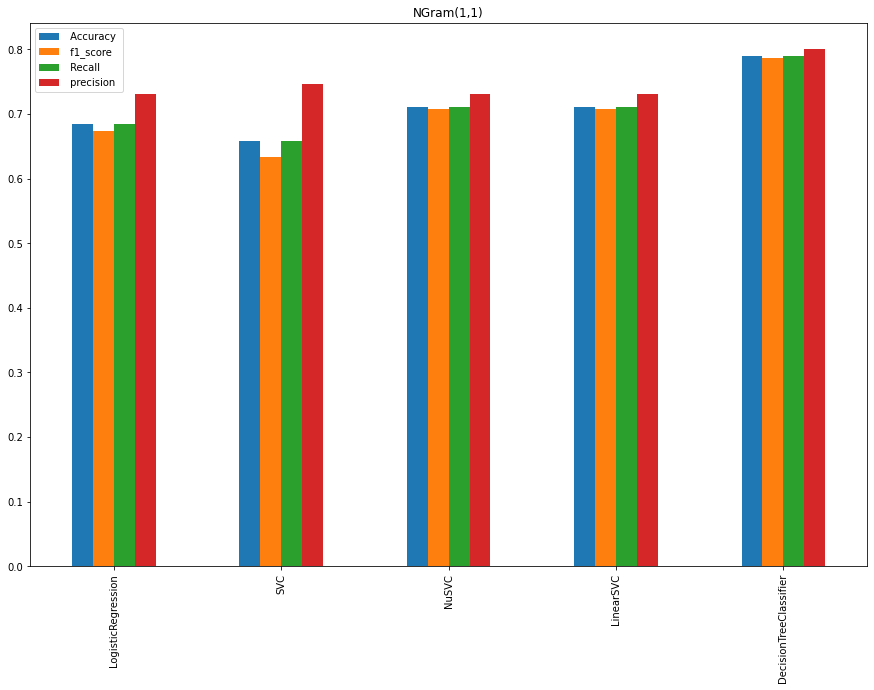

In [ ]:
ax = df.plot.bar(title ="NGram(1,1)", figsize=(15,10),legend=True)

In [ ]:
result="Classifier"+'*'+" Accuracy * f1_score * Recall * precision"+"\n"


In [ ]:
for classifier in cl:
    NGram_Evaluataion(classifier(),classifier.__name__,1,2) #N-gram range: one word "bigram"

LogisticRegression
accuracy 0.6578947368421053
f1_score 0.6330462987990887
recall 0.6578947368421053
precision 0.7455132083081266

 clasification report:
               precision    recall  f1-score   support

       False       0.59      0.94      0.72        18
        True       0.89      0.40      0.55        20

    accuracy                           0.66        38
   macro avg       0.74      0.67      0.64        38
weighted avg       0.75      0.66      0.63        38

SVC
accuracy 0.6578947368421053
f1_score 0.6330462987990887
recall 0.6578947368421053
precision 0.7455132083081266

 clasification report:
               precision    recall  f1-score   support

       False       0.59      0.94      0.72        18
        True       0.89      0.40      0.55        20

    accuracy                           0.66        38
   macro avg       0.74      0.67      0.64        38
weighted avg       0.75      0.66      0.63        38

NuSVC
accuracy 0.7105263157894737
f1_score 0.697453

In [ ]:
from io import StringIO 
df = pd.read_csv(StringIO(result), sep ="*") 
# Print the dataframe 
df

,Classifier,Accuracy,f1_score,Recall,precision
LogisticRegression,"Ngram(1,2)",0.657895,0.633046,0.657895,0.745513
SVC,"Ngram(1,2)",0.657895,0.633046,0.657895,0.745513
NuSVC,"Ngram(1,2)",0.710526,0.697453,0.710526,0.776715
LinearSVC,"Ngram(1,2)",0.710526,0.697453,0.710526,0.776715
DecisionTreeClassifier,"Ngram(1,2)",0.763158,0.762663,0.763158,0.763232


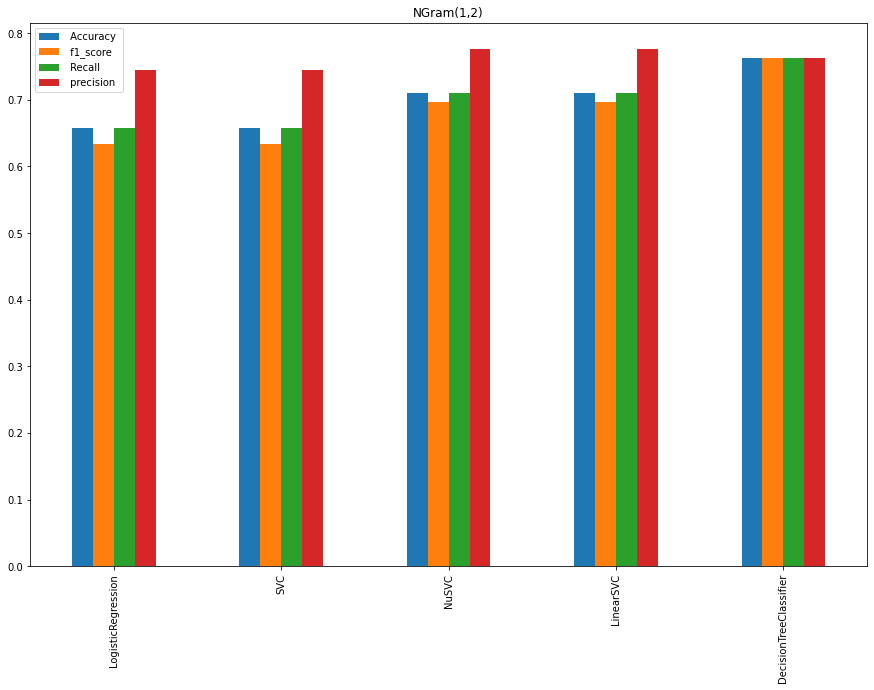

In [ ]:
ax = df.plot.bar(title ="NGram(1,2)", figsize=(15,10),legend=True)

In [ ]:
result="Classifier"+'*'+" Accuracy * f1_score * Recall * precision"+"\n"


In [ ]:
for classifier in cl:
    NGram_Evaluataion(classifier(),classifier.__name__,1,3) #N-gram range: one word "Trigram"

LogisticRegression
accuracy 0.6578947368421053
f1_score 0.6330462987990887
recall 0.6578947368421053
precision 0.7455132083081266

 clasification report:
               precision    recall  f1-score   support

       False       0.59      0.94      0.72        18
        True       0.89      0.40      0.55        20

    accuracy                           0.66        38
   macro avg       0.74      0.67      0.64        38
weighted avg       0.75      0.66      0.63        38

SVC
accuracy 0.6578947368421053
f1_score 0.6330462987990887
recall 0.6578947368421053
precision 0.7455132083081266

 clasification report:
               precision    recall  f1-score   support

       False       0.59      0.94      0.72        18
        True       0.89      0.40      0.55        20

    accuracy                           0.66        38
   macro avg       0.74      0.67      0.64        38
weighted avg       0.75      0.66      0.63        38

NuSVC
accuracy 0.7105263157894737
f1_score 0.697453

In [ ]:
from io import StringIO 
df = pd.read_csv(StringIO(result), sep ="*") 
# Print the dataframe 
df

,Classifier,Accuracy,f1_score,Recall,precision
LogisticRegression,"Ngram(1,3)",0.657895,0.633046,0.657895,0.745513
SVC,"Ngram(1,3)",0.657895,0.633046,0.657895,0.745513
NuSVC,"Ngram(1,3)",0.710526,0.697453,0.710526,0.776715
LinearSVC,"Ngram(1,3)",0.710526,0.697453,0.710526,0.776715
DecisionTreeClassifier,"Ngram(1,3)",0.789474,0.785885,0.789474,0.800752


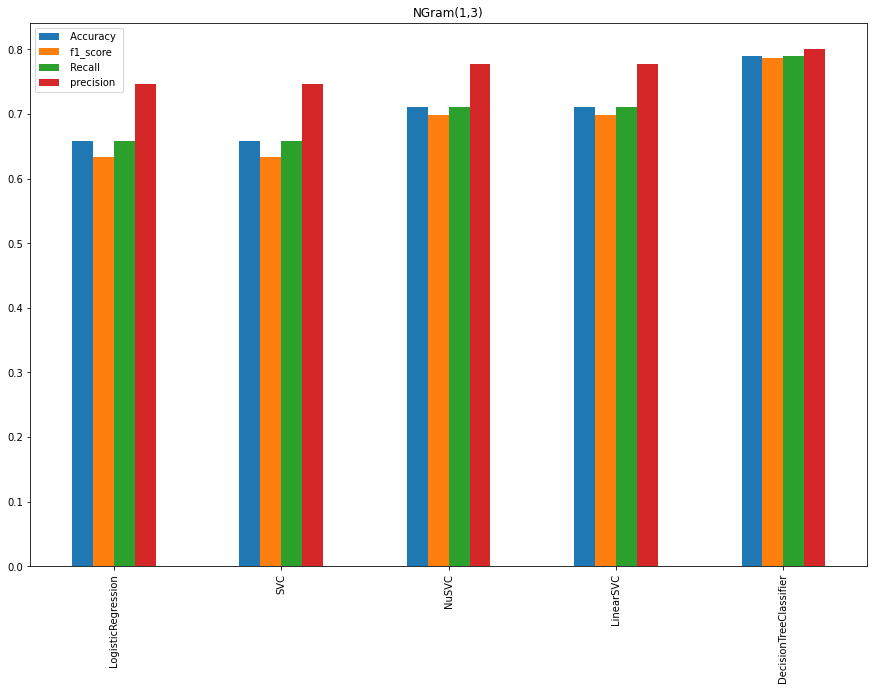

In [ ]:
ax = df.plot.bar(title ="NGram(1,3)", figsize=(15,10),legend=True)

**Validation**

**CrossValidatiom**

In [ ]:
from sklearn.model_selection import KFold 
from sklearn.metrics import *
result="classifier *  Accuracy * f1_score * Recall * precision"+"\n"
def test(s,clf, clf_name):
    global result
    kf = KFold(n_splits=s,shuffle=True, random_state=42) 
    i=0
    a=0
    avg_f=0
    avg_r=0
    avg_p=0
    for train_index, test_index in kf.split(data):
       
    #print("Train:", train_index, "Validation:",test_index)
        train_text=data.iloc[train_index]['Claim'].values
        train_y=data.iloc[train_index]['ClaimLabel'].values.astype(str)
   
        test_text=data.iloc[test_index]['Claim'].values
        test_y=data.iloc[test_index]['ClaimLabel'].values.astype(str)
        text_clf = Pipeline([('vect', CountVectorizer()),  # Counts occurrences of each word
                         # Normalize the counts based on document length
                         ('clf', clf()),
                         ])
    
        text_clf.fit(train_text,train_y)
        predicted = text_clf.predict(test_text)
        print('split'+str(len(test_y)/len(train_text)*100))
        # Compute accuracy
        acc = accuracy_score(test_y, predicted)
        f=f1_score(test_y, predicted,average='weighted')
        r=recall_score(test_y, predicted,average='weighted')
        p=precision_score(test_y, predicted,average='weighted')
        
        a+=acc
        avg_f+=f
        avg_r+=r
        avg_p+=p
        #result+=str(i)+'*'+str(acc)+'*'+str(f)+'*'+str(r)+'*'+str(p)+'\n'
        print("accuracy_fold_%s" % s, acc)
        print(clf.__class__.__name__)
        print("accuracy",accuracy_score(test_y, predicted))
        print("f1_score",f)
        print("recall",r)
        print("precision",p)
        print('-----')
        i+=1
        
    print("aaaa f1_score",avg_f)
    print("aaa recall",avg_r)
    print("aaa precision",avg_p)
    
    
    a=a/s
    avg_f/=s
    avg_r/=s
    avg_p/=s
    print("average accuracy", a)
   
    print("average f1_score",avg_f)
    print("average recall",avg_r)
    print("average precision",avg_p)
    result+=clf_name+'*'+str(a)+'*'+str(avg_f)+'*'+str(avg_r)+'*'+str(avg_p)+'\n'

In [ ]:
k=[10]

In [ ]:
from sklearn.pipeline import Pipeline #assemble several steps that can be cross-validated together while setting different parameters.

In [ ]:
for classifier in cl:
    for kf in k:
        test(kf,classifier,classifier.__name__)

split11.242603550295858
accuracy_fold_10 0.9473684210526315
type
accuracy 0.9473684210526315
f1_score 0.9476632758366504
recall 0.9473684210526315
precision 0.9532163742690059
-----
split11.242603550295858
accuracy_fold_10 0.8421052631578947
type
accuracy 0.8421052631578947
f1_score 0.8429898275099513
recall 0.8421052631578947
precision 0.8485380116959065
-----
split11.242603550295858
accuracy_fold_10 0.6842105263157895
type
accuracy 0.6842105263157895
f1_score 0.6558704453441294
recall 0.6842105263157895
precision 0.7017543859649122
-----
split11.242603550295858
accuracy_fold_10 0.631578947368421
type
accuracy 0.631578947368421
f1_score 0.631578947368421
recall 0.631578947368421
precision 0.6638755980861244
-----
split11.242603550295858
accuracy_fold_10 0.631578947368421
type
accuracy 0.631578947368421
f1_score 0.631578947368421
recall 0.631578947368421
precision 0.7255639097744361
-----
split11.242603550295858
accuracy_fold_10 0.8421052631578947
type
accuracy 0.8421052631578947
f1_sc

In [ ]:
from io import StringIO 
df = pd.read_csv(StringIO(result), sep ="*")#, error_bad_lines=False) 
# Print the dataframe 
df

,classifier,Accuracy,f1_score,Recall,precision
0,LogisticRegression,0.786842,0.784450,0.786842,0.807375
1,SVC,0.750000,0.743032,0.750000,0.785735
2,NuSVC,0.797661,0.795577,0.797661,0.820754
3,LinearSVC,0.797076,0.795430,0.797076,0.812585
4,DecisionTreeClassifier,0.754971,0.755384,0.754971,0.768136


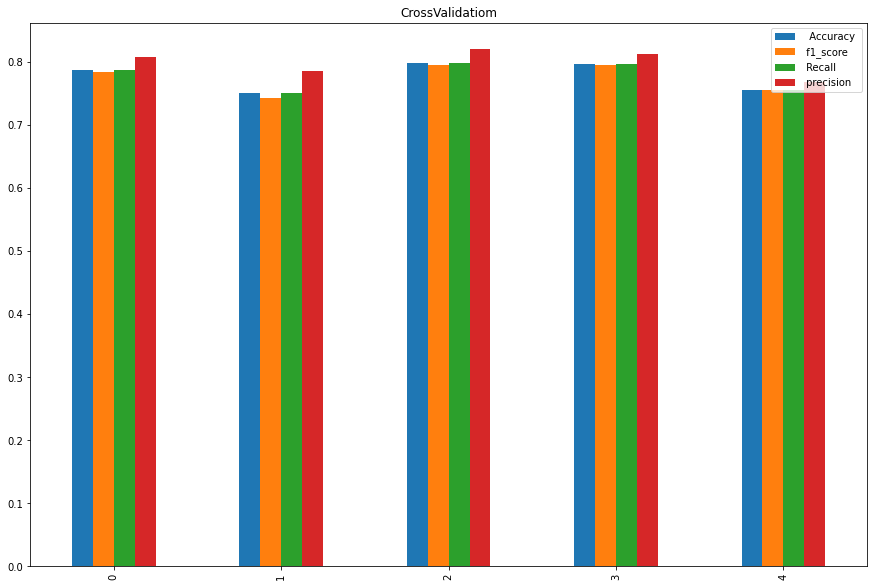

In [ ]:
ax = df.plot.bar(title ="CrossValidatiom", figsize=(15,10),legend=True)